In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model

Essential info about tagged entities:
```
geo = Geographical Entity
org = Organization
per = Person
gpe = Geopolitical Entity
tim = Time indicator
art = Artifact
eve = Event
nat = Natural Phenomenon
```

In [4]:

data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [5]:
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [6]:
data = data.fillna(method="ffill")

In [7]:
data.head(5)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [8]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 13134
Unique tags in corpus: 17


In [9]:
data.shape

(145102, 4)

In [10]:
words=list(data['Word'].unique())
words.append("ENDPAD")
tags=list(data['Tag'].unique())


In [11]:
print("Unique tags are:", tags)

Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [12]:
num_words = len(words)
num_tags = len(tags)

In [13]:
num_words

13135

In [14]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [15]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [16]:
len(sentences)

6612

In [17]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [18]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [19]:
word2idx

{'Thousands': 1,
 'of': 2,
 'demonstrators': 3,
 'have': 4,
 'marched': 5,
 'through': 6,
 'London': 7,
 'to': 8,
 'protest': 9,
 'the': 10,
 'war': 11,
 'in': 12,
 'Iraq': 13,
 'and': 14,
 'demand': 15,
 'withdrawal': 16,
 'British': 17,
 'troops': 18,
 'from': 19,
 'that': 20,
 'country': 21,
 '.': 22,
 'Families': 23,
 'soldiers': 24,
 'killed': 25,
 'conflict': 26,
 'joined': 27,
 'protesters': 28,
 'who': 29,
 'carried': 30,
 'banners': 31,
 'with': 32,
 'such': 33,
 'slogans': 34,
 'as': 35,
 '"': 36,
 'Bush': 37,
 'Number': 38,
 'One': 39,
 'Terrorist': 40,
 'Stop': 41,
 'Bombings': 42,
 'They': 43,
 'Houses': 44,
 'Parliament': 45,
 'a': 46,
 'rally': 47,
 'Hyde': 48,
 'Park': 49,
 'Police': 50,
 'put': 51,
 'number': 52,
 'marchers': 53,
 'at': 54,
 '10,000': 55,
 'while': 56,
 'organizers': 57,
 'claimed': 58,
 'it': 59,
 'was': 60,
 '1,00,000': 61,
 'The': 62,
 'comes': 63,
 'on': 64,
 'eve': 65,
 'annual': 66,
 'conference': 67,
 'Britain': 68,
 "'s": 69,
 'ruling': 70,
 'L

In [20]:
tag2idx

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

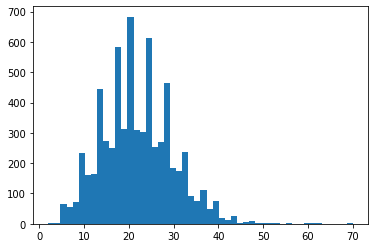

In [21]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [22]:
X1 = [[word2idx[w[0]] for w in s] for s in sentences]

In [23]:
type(X1[0])

list

In [24]:
X1[0]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 10,
 16,
 2,
 17,
 18,
 19,
 20,
 21,
 22]

In [25]:
max_len = 50

# **pad_sequences example**

In [26]:
nums = [[1], [2, 3], [4, 5, 6]]
sequence.pad_sequences(nums)

array([[0, 0, 1],
       [0, 2, 3],
       [4, 5, 6]], dtype=int32)

In [27]:
nums = [[1], [2, 3], [4, 5, 6]]
sequence.pad_sequences(nums,maxlen=2)

array([[0, 1],
       [2, 3],
       [5, 6]], dtype=int32)

In [28]:
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)

In [29]:
X[1]

array([  125,   126,   127,   128,   129,     8,   130,   131,     8,
         132,   133,   119,     2,    10,   124,   108,    94,   134,
         135,   136,   137,   138,   139,   140,    22, 13134, 13134,
       13134, 13134, 13134, 13134, 13134, 13134, 13134, 13134, 13134,
       13134, 13134, 13134, 13134, 13134, 13134, 13134, 13134, 13134,
       13134, 13134, 13134, 13134, 13134], dtype=int32)

In [30]:
tag2idx

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [31]:
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]

In [32]:
y1[0]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]

In [33]:
y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1)

In [35]:
X_train[7]

array([   62, 10676,    94, 10677,  3806,    94,    79,   348,     2,
         388,   325,   354,   323,   812,   224,  4683,  2513,     8,
        9175,   731,  2040,  1217,     2,  5078,   244,     2,   846,
          22, 13134, 13134, 13134, 13134, 13134, 13134, 13134, 13134,
       13134, 13134, 13134, 13134, 13134, 13134, 13134, 13134, 13134,
       13134, 13134, 13134, 13134, 13134], dtype=int32)

In [36]:
y_train[0]

array([0, 1, 0, 0, 0, 5, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [37]:
input_word = layers.Input(shape=(max_len,))
embedding_layer=layers.Embedding(input_dim=num_words,output_dim=50,input_length=max_len)(input_word)
dropout_layer=layers.SpatialDropout1D(0.1)(embedding_layer)
bidirectional_lstm=layers.Bidirectional(
    layers.LSTM(units=100,return_sequences=True,
                recurrent_dropout=0.1))(dropout_layer)
output=layers.TimeDistributed(
      layers.Dense(num_tags,activation="softmax"))(bidirectional_lstm)
model = Model(input_word, output)

In [42]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            656750    
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [44]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=32, 
    epochs=3,
)

Epoch 1/3
166/166 [==============================] - 58s 330ms/step - loss: 0.1114 - accuracy: 0.9684 - val_loss: 0.1112 - val_accuracy: 0.9707
Epoch 2/3
166/166 [==============================] - 54s 326ms/step - loss: 0.0764 - accuracy: 0.9789 - val_loss: 0.0909 - val_accuracy: 0.9751
Epoch 3/3
166/166 [==============================] - 55s 329ms/step - loss: 0.0563 - accuracy: 0.9842 - val_loss: 0.0855 - val_accuracy: 0.9770


In [45]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.111396,0.968376,0.111187,0.970703
1,0.076354,0.978930,0.090910,0.975117
2,0.056259,0.984190,0.085517,0.977022


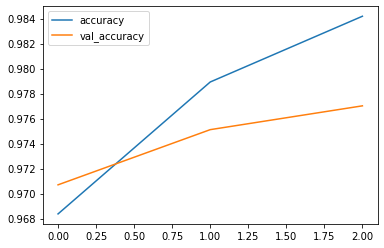

In [46]:
metrics[['accuracy','val_accuracy']].plot()

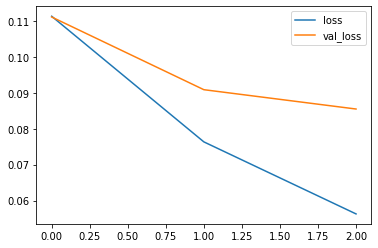

In [47]:
metrics[['loss','val_loss']].plot()

In [50]:
i = 6
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 72ms/step
Word           True 	 Pred

------------------------------
NATO           B-org	B-org
and            O	O
U.S.           B-geo	B-geo
forces         O	O
are            O	O
battling       O	O
a              O	O
resurgent      O	O
Taliban        B-org	B-org
presence       O	O
in             O	O
Afghanistan    B-geo	B-geo
.              O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
comatose       O	O
co